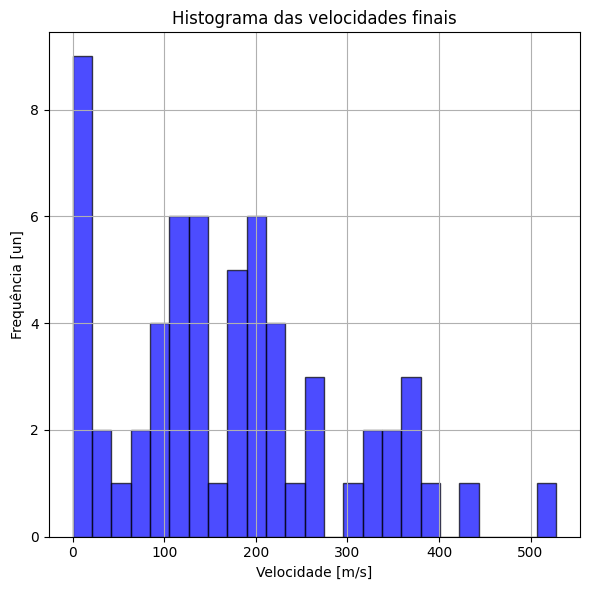

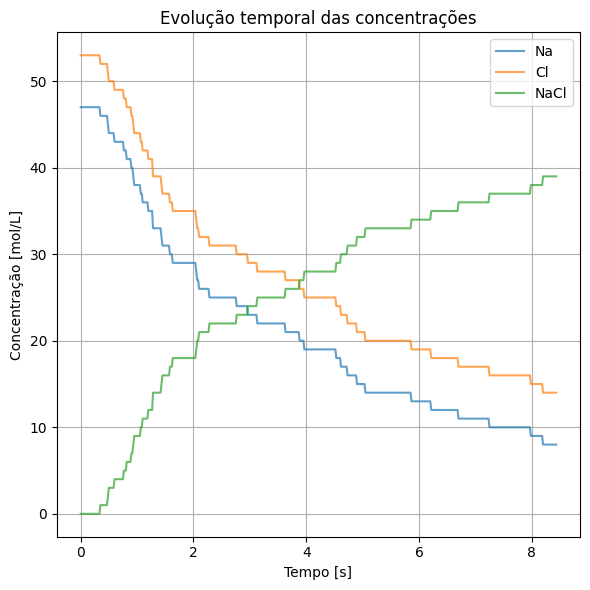

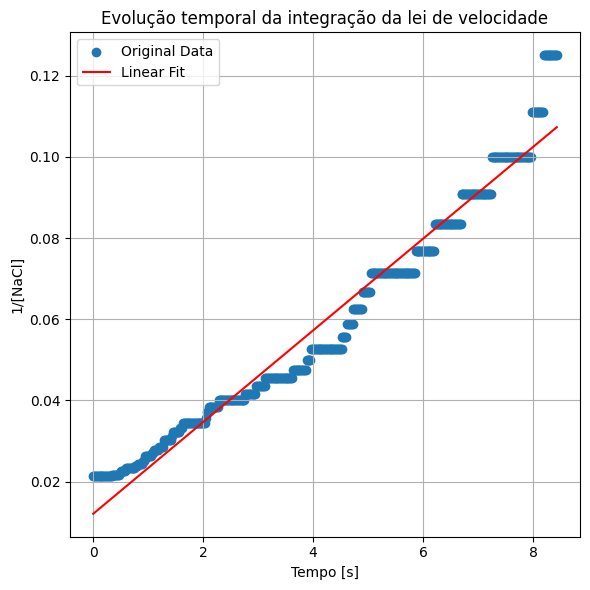

[[Model]]
    Model(quadratic_model)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 506
    # variables        = 1
    chi-square         = 134629.843
    reduced chi-square = 266.593749
    Akaike info crit   = 2827.37635
    Bayesian info crit = 2831.60288
    R-squared          = 0.01571015
[[Variables]]
    a: -0.00607473 +/- 8.7092e-04 (14.34%) (init = 1)


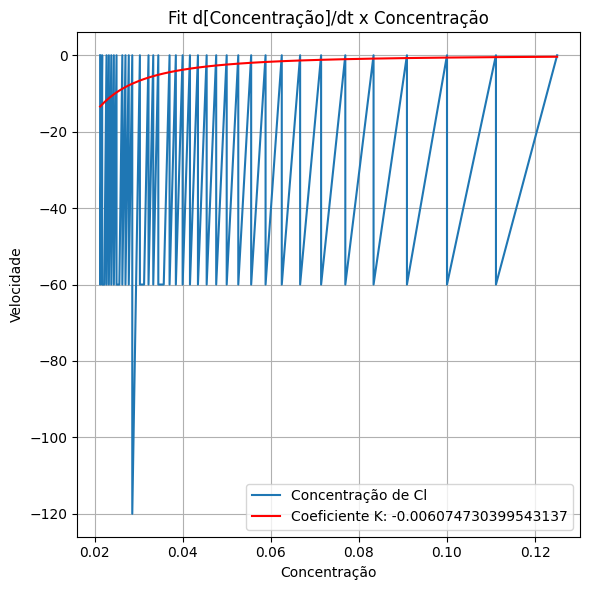

Temperatura Final do Sistema: 0.53 K


SystemExit: 

C:\venv\ilumpy-VS\lib\site-packages\IPython\core\interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [21]:
#Debugging 14-11-2023 == FALSE_V1; LATEST STABLE == V1
#UI == pygame
#Implementado gráfico Max-Boltz
#Implementação do fit da Lei de Velocidade
#'future' funciona (inherited 6_10)
#Colisão inelástica e elástica implementada
#Colisão futura implementada em classe Particul
#Reação química feita + grafico conc./tempo
#Fazer: encontrar a lei de velocidade (derivadas)
#Problemas: 
# -não é vetorializado
# -baixa eficiência por itertools
# -NA_CL_INDEX como global
# -a = 'Na', b = 'Cl'; a = 'Cl', b = 'Na'-> e se forem 3?
# -intersection_position_checker que nao precisa checar tudo ?
# -reações que geram partículas grandes podem gerar intersecção com outra que está indo em direção a esta

# Catálise homogênea e heterogênea - ver sobre
# Adição do catalisador como parede -> vel == 0 True
# O código é sobre heterogenea
# Adicionado 'states' para entender quais colisões e reações

#Vetorialização:
#Usar arrays; mínimo de for's e while's (loops); numpy; scipy cdist; numpy.greater

import random
import warnings
import pygame
from pygame.locals import *
from sys import exit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import ExponentialModel, LinearModel
from lmfit import Model, Parameters
import itertools

# VERSION
VERSION = '6_19_4'

# Constants
FPS = 60
DT = 1/FPS
ALTURA_CAIXA = 500
LARGURA_CAIXA = 500
NUM_PARTICULAS = 100
#GRID_SIZE = 10
FUTURE_FACTOR = 1.5
TIPO_COLISAO = 'elastic'
COEFICIENTE_RESTITUICAO = 0.0 #coeficiente de restituição

AVOGADRO_CONSTANT = 6.022e23 #constante de avogadro
BOLTZMANN_CONSTANT = 1.380649e-23 #m2 kg s-2 K-1

MASSA_PROTON = 1.67262192e-27 #em Kg
MASSA_NEUTRON = 1.65e-27 #em Kg

NAME_BOLTZ = f'max-boltz_{VERSION}.png'
NAME_CONCENTRATION_PLOT = f'concentration_{VERSION}.png'
NAME_INTEGRATION_RATE_LAW_PLOT = f'inverse_concentration_{VERSION}.png'
NAME_FIT_CONCENTRATION_PLOT = f'fit_concentration_{VERSION}.png'
NAME_VEL_RATE = f'velocidade_reacao_{VERSION}.png'
NAME_CHEMICAL_CSV = f'df_chemical_data_{VERSION}.csv'
NAME_MOLARITY_CSV = f'df_molarity_data_{VERSION}.csv'

# Indexes de moléculas das reações
NA_CL_INDEX = 0
CHANCE_NACL_GLOBAL = 0.4 #chances de não acontecer a reação

# Colors
WHITE = (255, 255, 255)

class Particula:
    def __init__(self, p_type, state, massa, raio, vel_x, vel_y, x, y, chance_reaction,cor):
        self.p_type = p_type
        self.state = state
        self.massa = float(massa)
        self.raio = float(raio)
        self.vel_x = float(vel_x)
        self.vel_y = float(vel_y)
        self.x = float(x)
        self.y = float(y)
        self.x_future = None
        self.y_future = None
        self.chance_reaction = chance_reaction
        self.cor = cor
        self.sprite_pygame = self.sprite_pygame()

    def deslocar(self):

        self.x += self.vel_x * DT
        self.y += self.vel_y * DT

    def next_position(self):
        self.x_future = self.x + self.vel_x * DT * FUTURE_FACTOR
        self.y_future = self.y + self.vel_y * DT * FUTURE_FACTOR

        if self.x_future < self.raio or self.x_future > LARGURA_CAIXA - self.raio:
            if self.p_type == "Na":
                self.state = 'fixed'
                self.vel_x = 0.0
                self.vel_y = 0.0
                self.chance_reaction = 1.0
            else:    
                self.vel_x *= -1
            #print("ativada por x")
        if self.y_future < self.raio or self.y_future > ALTURA_CAIXA - self.raio:
            if self.p_type == "Na":
                self.state = 'fixed'
                self.vel_x = 0.0
                self.vel_y = 0.0
                self.chance_reaction = 1.0
            else:
                self.vel_y *= -1
            #print("ativada por y")

        #print('next_position')

    def sprite_pygame(self):
        circle = pygame.Surface((self.raio * 2, self.raio * 2), pygame.SRCALPHA)
        pygame.draw.circle(circle, self.cor, (self.raio, self.raio), self.raio)
        sprite = pygame.sprite.Sprite()
        sprite.image = circle
        sprite.rect = sprite.image.get_rect(center=(self.x, self.y))
        return sprite

def check_collision(p1, p2):

    p1.next_position() #proxima_posicao

    p2.next_position() #proxima_posicao

    distance_future = np.sqrt((p2.x_future - p1.x_future)**2 + (p2.y_future - p1.y_future)**2)
    #distance = np.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)
    if (distance_future <= p1.raio + p2.raio) == True:
        return True
    else:
        return False


def reaction_collision(particles, p1, p1_index, p2, p2_index, sprites):

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    vel_new_particle = ((p1.massa * v1) + (p2.massa * v2)) / (p1.massa + p2.massa) #apenas momento conservado

    #print('arrays_reaction_v:', v1, v2)

    CM_x = (p1.massa * p1.x + p2.massa * p2.x) / (p1.massa + p2.massa)
    CM_y = (p1.massa * p1.y + p2.massa * p2.y) / (p1.massa + p2.massa)

    p1_chance = p1.chance_reaction #chance de acontecer a reação
    p2_chance = p2.chance_reaction

    remove_particles = []
    add_particles = []

    #print('arrays_reaction_CM:', CM_x, CM_y )

    #new_particles = particles.copy()
    #print('old_particles:', particles)


    if ((p1.p_type == 'Na' and p2.p_type == 'Cl') or (p1.p_type == 'Cl' and p2.p_type == 'Na')) and (p1_chance > CHANCE_NACL_GLOBAL or p2_chance > CHANCE_NACL_GLOBAL):
        #print(p1.p_type, p2.p_type, 'form NaCl')

        global NA_CL_INDEX

        p_type = 'NaCl'
        state = 'mobile'
        massa = (p1.massa + p2.massa)
        raio = 5
        vel_x = vel_new_particle[0]
        vel_y = vel_new_particle[1]
        x = CM_x
        y = CM_y
        #x_future = x + vel_x * DT * FUTURE_FACTOR
        #y_future = y + vel_y * DT * FUTURE_FACTOR
        chance_reaction = 0.00005
        cor = (125, 125, 125)
        nome_particula = f"{p_type}_{NA_CL_INDEX}" 
        particle_instance = Particula(p_type, state, massa,raio, vel_x, vel_y, x, y, chance_reaction,cor)

        sprites.add(particle_instance.sprite_pygame)
        
        NA_CL_INDEX += 1

        add_particles.extend([{nome_particula : particle_instance}])
        #print(add_particles)

        #print("Before deletion:", particles.keys())
        #print(f"Deleting particles with indices: {p1_index}, {p2_index}")


        remove_particles.extend([p1_index, p2_index])
        #print(remove_particles)

        #del particles[p1_index]
        #del particles[p2_index]

        #print("After deletion:", particles.keys())

        p1.sprite_pygame.kill()
        p2.sprite_pygame.kill()

        return add_particles, remove_particles

    if p1.state == 'mobile' and p2.state == 'mobile':
        resolve_collision(p1,p2,collision_type=TIPO_COLISAO)
        return add_particles, remove_particles

    if ((p1.p_type == 'Na' and p2.p_type == 'NaCl') or (p1.p_type == 'NaCl' and p2.p_type == 'Na')):
        #print('Na + NaCl')

        if p2.state == 'fixed':
            p1.vel_x *= -1
            p1.vel_y *= -1

        if p1.state == 'fixed':
            p2.vel_x *= -1
            p2.vel_y *= -1

        return add_particles, remove_particles


    if ((p1.p_type == 'Na' and p2.p_type == 'Na') or (p1.p_type == 'Na' and p2.p_type == 'Na')):

        if p2.state == 'fixed':
            p1.vel_x *= -1
            p2.vel_y *= -1

        if p1.state == 'fixed':
            p2.vel_x *= -1
            p2.vel_y *= -1

        return add_particles, remove_particles

    else:
        #print('does not react')
        #print('collision solved')
        resolve_collision(p1,p2,collision_type=TIPO_COLISAO)
        return add_particles, remove_particles

    #print('new_particles:',particles)
    #print()

    #return particles
    #return deve ser dado depois de cada if se nn o else roda e resolve a colisão


def resolve_collision(p1, p2, collision_type='elastic'):
    x1 = np.array([p1.x, p1.y])
    x2 = np.array([p2.x, p2.y])

    #print('arrays_x:', x1, x2)

    v1 = np.array([p1.vel_x, p1.vel_y])
    v2 = np.array([p2.vel_x, p2.vel_y])

    #print('arrays_v:', v1, v2)

    if collision_type == 'elastic' or collision_type == 'elastica':
        #print('elastica')

        C = 1

    if collision_type == 'partial_inelastic' or collision_type == 'parcial_inelastica':
        #print('inelastica')

        C = COEFICIENTE_RESTITUICAO

    new_v1 = v1 - ((((C * p2.massa) + p2.massa) / (p1.massa + p2.massa)) * ((np.dot((v1 - v2),(x1 - x2))) / ((np.linalg.norm(x1 - x2))**2)) * (x1 - x2))
    new_v2 = v2 - ((((C * p1.massa) + p1.massa) / (p1.massa + p2.massa)) * ((np.dot((v2 - v1),(x2 - x1))) / ((np.linalg.norm(x2 - x1))**2)) * (x2 - x1))

    p1.vel_x = new_v1[0]
    p1.vel_y = new_v1[1]
    p2.vel_x = new_v2[0]
    p2.vel_y = new_v2[1]

    #print('resolution',p1.vel_x, p1.vel_y, p2.vel_x, p2.vel_y)

#src_elastica = https://en.wikipedia.org/wiki/Elastic_collision#Two-dimensional_collision_with_two_moving_objects
#src_inelastica = https://physics.stackexchange.com/questions/708495/angle-free-two-dimensional-inelastic-collision-formula




def gerar_particula(n_particulas):
    particulas = {}

    #atomos
    atomos = {
        "Na": {"massa": 11*MASSA_PROTON + 12*MASSA_NEUTRON, "raio": 5, "color": (255, 0, 0)}, #approximations
        "Cl": {"massa": 17*MASSA_PROTON + 18*MASSA_NEUTRON, "raio": 5, "color": (0, 255, 0)},
        #"NaCl" : {"massa": 11*MASSA_PROTON + 12*MASSA_NEUTRON + 17*MASSA_PROTON + 18*MASSA_NEUTRON, "raio": 5, "color": (125, 125, 125)} #testes

    }

    for particle_index in range(1, n_particulas + 1):

        #escolha de distribuição aleatória
        atomos_selecionar = random.choice(list(atomos.keys()))

        attributes = atomos[atomos_selecionar]

        p_type = atomos_selecionar
        state = 'mobile'
        massa = attributes["massa"]
        raio = attributes["raio"]
        vel = random.uniform(100,600)
        vel_angle = np.random.uniform(0, 2 * np.pi)
        vel_x = vel * np.cos(vel_angle) #velocidade inicial não especificada
        vel_y = vel * np.sin(vel_angle)
        x = random.uniform(raio, LARGURA_CAIXA - raio)
        y = random.uniform(raio, ALTURA_CAIXA - raio)
        #x_future = x + vel_x * DT * FUTURE_FACTOR
        #y_future = y + vel_y * DT * FUTURE_FACTOR
        chance_reaction = 0.00005
        cor = attributes["color"]
        nome_particula = f"{atomos_selecionar}_{particle_index}" 
        particle_instance = Particula(p_type, state, massa, raio, vel_x, vel_y, x, y, chance_reaction, cor)
        particulas[nome_particula] = particle_instance
        #print(vel_x,vel_y,vel,vel_angle)

    return particulas

def select_particles(particles,sprites):
    copy_particles = particles.copy()
    all_update = []
    all_remove = []

    for (name_p1, instance_p1), (name_p2, instance_p2) in itertools.combinations(particles.items(), 2):
        #print((name_p1, type(instance_p1)), (name_p2, type(instance_p2)))
        if check_collision(instance_p1, instance_p2):
            #print('foi pra reacted')
            reacted_particles = reaction_collision(particles, instance_p1, name_p1, instance_p2, name_p2,sprites)

            all_update.extend(reacted_particles[0])
            all_remove.extend(reacted_particles[1])
            


    for particle_name in all_remove:
        del copy_particles[particle_name]

    for particle_dict in all_update:
        copy_particles.update(particle_dict)

    return copy_particles



def intersection_pos_checker(particles,iteration_max = 100):
    iteration_count = 0
    intersection = False
    #particle_pairs = np.array(list(itertools.permutations(particles.items(), 2)))
    for (name_p1, instance_p1), (name_p2, instance_p2) in itertools.combinations(particles.items(), 2):
        if check_collision(instance_p1, instance_p2):
                particle_move = random.choice([[name_p1,instance_p1], [name_p2,instance_p2]])
                new_x = random.uniform(particle_move[1].raio, LARGURA_CAIXA - (particle_move[1].raio))
                new_y = random.uniform(particle_move[1].raio, ALTURA_CAIXA - (particle_move[1].raio))
                particles[particle_move[0]].x = new_x
                particles[particle_move[0]].y = new_y
                iteration_count +=1
                #print(particles[particle_move[0]].y) #verificar coordenadas alteradas

                intersection = True
                if iteration_max == iteration_count:
                    warnings.warn(f'{iteration_max} iterações atingidas. Deve haver partículas sobrepostas. Altere o tamanho da caixa.')
                    return particles
    
    if intersection == True:
        #print('True')
        return intersection_pos_checker(particles)

    if intersection == False:
        #print('False')
        return particles


def create_particle_group_sprites(particles):
    sprites = pygame.sprite.Group()
    for particle_instance in particles.values():
        sprite = particle_instance.sprite_pygame
        sprites.add(sprite)
    #print(sprites)
    return sprites


def chemical_counter(particles,time_passed,system_temperature,df=pd.DataFrame()):
    chem_list = particles.keys()

    element_count = {}  # Initialize an empty dictionary to store element counts

    for item in chem_list:
        element = item.split('_')[0]  # Extract the element (part before the underscore)
        if element in element_count:
            element_count[element] += 1  # Increment the count if the element already exists
        else:
            element_count[element] = 1  # Initialize count to 1 if the element is encountered for the first time


    chem_array = np.concatenate((np.array([time_passed]),np.array([system_temperature]),np.array(list(element_count.values()))))
    df_chem = pd.DataFrame(chem_array).T
    df_chem.columns = np.concatenate((np.array(['Tempo [s]']),np.array(['Temperatura [K]']),np.array(list(element_count.keys()))))

    df_chem = pd.concat([df, df_chem], axis=0, ignore_index=True)

    return df_chem


def convert_to_molarity(df,liter):
    df_molar = df.copy()
    for column in range(1,df_molar.shape[1]):
        #print(column)
        df_molar.iloc[:,column] = ((df_molar.iloc[:,column]/AVOGADRO_CONSTANT)/liter)
    return df_molar

def determine_temperature(particles): #determina a temperatura baseada na média da vel. quadrada
    # sai de m*<v^2>/2 = 1/2 * 2 kt
    #nesse caso: <m*v**2>/2 = 0.5 * k*T
    array_vel_x = np.array([particle.vel_x for particle in particles.values()])
    array_vel_y = np.array([particle.vel_y for particle in particles.values()])
    array_massa = np.array([particle.massa for particle in particles.values()])

    mass_vel_average = np.mean(array_massa * np.sqrt((array_vel_x**2) + (array_vel_y**2)))
    temperature = mass_vel_average / (2*BOLTZMANN_CONSTANT) #dois graus de liberdade; sai em K

    return temperature


def vel_rate_plot(df,name):
    #print(data_vel_fit['resultado_fit_1'])
    #print(data_vel_fit['resultado_fit_1'].best_fit)

    dt = df['Tempo [s]'][1] - df['Tempo [s]'][0]
    derivative = np.diff(df['Na']) / dt
    concentrations = df['Na'][:-1]


    # Define the quadratic model function
    def quadratic_model(x, a):
        return a * x**2
        
    mod = Model(quadratic_model)

# Automatically guess initial parameter values
    params_quadratic = Parameters()
    params_quadratic.add('a', value=1.0)
    #params_quadratic.add('b', value=1.0)
    #params_quadratic.add('c', value=1.0)

    # Perform the fit
    result_quadratic = mod.fit(derivative, params_quadratic, x=concentrations)

    # Print and visualize the fit results
    print(result_quadratic.fit_report())
    a_value = result_quadratic.params['a'].value
    #b_value = result_quadratic.params['b'].value
    #c_value = result_quadratic.params['c'].value

    fig2, ax2 = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    #ax2.plot(data_vel_fit['y1_data'], derivative_1, label = "Velocidade em Cl")
    ax2.plot(1/concentrations,derivative, label = "Concentração de Cl")
    ax2.plot(1/concentrations, result_quadratic.best_fit, label=f"Coeficiente K: {a_value}", color='red')

    plt.title('Fit d[Concentração]/dt x Concentração')
    plt.xlabel('Concentração')
    plt.ylabel('Velocidade')
    plt.legend()
    plt.grid(True)
    fig2.tight_layout()
    fig2.savefig(name)  # Salva a figura
    plt.show()

def maxwell_boltzmann_plot(final_speeds,name):
    # Barplot/histograma das velocidades Max-Boltz.
    fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    plt.hist(final_speeds, bins=25, color='blue', edgecolor='black', alpha=0.7)
    plt.xlabel('Velocidade [m/s]')
    plt.ylabel('Frequência [un]')
    plt.title('Histograma das velocidades finais')
    plt.grid(True)
    fig.tight_layout()
    fig.savefig(name)  # Salva a figura
    plt.show()

def concentration_plot(df,name):
    # Lineplot das concentrações/tempo.
    fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    for y_axis, labels in zip(df.columns[2:],list(df.columns)[2:]):
        plt.plot(df['Tempo [s]'],(df[y_axis]),alpha=0.7, label=labels)
    plt.legend()
    plt.xlabel('Tempo [s]')
    plt.ylabel('Concentração [mol/L]')
    plt.title('Evolução temporal das concentrações')
    plt.grid(True)
    fig.tight_layout()
    fig.savefig(name)  # Salva a figura
    plt.show()

def integration_rate_law_plot(df,name):
    inverse = (1/df['Na'])
    # Lineplot das concentrações/tempo.
    fig, ax = plt.subplots(figsize=(6, 6))  # Cria caixa para plot
    model = LinearModel()
    params = model.make_params(slope=1, intercept=1)
    result = model.fit(inverse, params, x=df['Tempo [s]'])
    slope = result.params['slope'].value
    intercept = result.params['intercept'].value
    plt.scatter(df['Tempo [s]'], inverse, label='Original Data')
    plt.plot(df['Tempo [s]'], result.best_fit, label='Linear Fit', color='red') 


    #plt.plot(df['Tempo [s]'],(df[y_axis]),alpha=0.7, label=labels)
    plt.legend()
    plt.xlabel('Tempo [s]')
    plt.ylabel('1/[NaCl]')
    plt.title('Evolução temporal da integração da lei de velocidade')
    plt.grid(True)
    fig.tight_layout()
    fig.savefig(name)  # Salva a figura
    plt.show()



def main():
    final_speeds = []
    pygame.init()
    screen = pygame.display.set_mode((LARGURA_CAIXA, ALTURA_CAIXA))
    pygame.display.set_caption("Collision Simulation")

    particles = gerar_particula(NUM_PARTICULAS)
    particles = intersection_pos_checker(particles)
    sprites = create_particle_group_sprites(particles)

    #digito_atual = 0
    time_passed = 0
    system_temperature = determine_temperature(particles)
    #print('temperatura', type(system_temperature))
    df_chem = chemical_counter(particles, time_passed, system_temperature)

    #grid = Grid(LARGURA_CAIXA, ALTURA_CAIXA, GRID_SIZE)

    clock = pygame.time.Clock()

    while True:
        for event in pygame.event.get():
            if event.type == QUIT:
                pygame.quit()

                # Pegar velocidades finais de todas as particulas
                for particle_instance in particles.values():
                    final_speed = np.sqrt(particle_instance.vel_x**2 + particle_instance.vel_y**2)
                    final_speeds.append(final_speed)

                maxwell_boltzmann_plot(final_speeds,name=NAME_BOLTZ) #desligado para teste

                df_chem = df_chem.fillna(0)
                df_chem.to_csv(NAME_CHEMICAL_CSV, index=False)
                #df_chem_molarity = convert_to_molarity(df_chem,1)
                #df_chem_molarity.to_csv(NAME_MOLARITY_CSV, index=False)
                concentration_plot(df_chem,name=NAME_CONCENTRATION_PLOT)
                integration_rate_law_plot(df_chem,name=NAME_INTEGRATION_RATE_LAW_PLOT)
                #data_fit = fit_concentration_plot(df_chem,name=NAME_FIT_CONCENTRATION_PLOT)
                vel_rate_plot(df_chem,name=NAME_VEL_RATE)
                #print(df_chem_molarity)
                print(f'Temperatura Final do Sistema: {np.round(system_temperature,decimals=2)} K')
                exit()

        time_passed += DT
        #primeiro_digito = int(time_passed)

        #if (digito_atual == 0) or (digito_atual != primeiro_digito):
         #   primeiro_digito = digito_atual
            #print('novo df_chem')
        system_temperature = determine_temperature(particles)
        #print('temperatura', system_temperature)
        df_chem = chemical_counter(particles,time_passed,system_temperature,df_chem)
            

        #print('after_reaction')
        particles = select_particles(particles,sprites)
        #print(type(after_reaction_particles))

        # Update particle positions after collision detection
        for particle_name, particle_instance in particles.items():
            particle_instance.deslocar()
            particle_instance.next_position() #usado para calcular if colisao == True
            #print('Debugger:',particle_instance.x, particle_instance.y, particle_instance.x_future, particle_instance.y_future)

        # Update sprite positions
        for sprite, particle_instance in zip(sprites, particles.values()):
            sprite.rect.center = (particle_instance.x, particle_instance.y)

        #print(time_passed)

        screen.fill(WHITE)
        sprites.draw(screen)

        pygame.display.flip()
        clock.tick(FPS)

if __name__ == "__main__":
    main()